## Install dependencies

Mount GoogleDrive if not already monted

In [ ]:
from google.colab import drive
from os.path import join
ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Mp_scRNA-seq'       # path to your project on Drive
drive.mount(ROOT)           # we mount the drive at /content/drive

Mounted at /content/drive


Install required packages

In [ ]:
!pip install scanpy loompy scvelo anndata velocyto python-igraph louvain leidenalg

In [ ]:
!pip install git+https://github.com/pachterlab/kb_python@count-kite

  Cloning https://github.com/pachterlab/kb_python (to revision count-kite) to /tmp/pip-req-build-nk1lukdz
  Running command git clone -q https://github.com/pachterlab/kb_python /tmp/pip-req-build-nk1lukdz
  Running command git checkout -q count-kite
  error: pathspec 'count-kite' did not match any file(s) known to git.
ERROR: Command errored out with exit status 1: git checkout -q count-kite Check the logs for full command output.


Change to correct directory if not already there

In [ ]:
cd drive/My\ Drive/Mp_scRNA-seq/analysis/

/content/drive/My Drive/Mp_scRNA-seq/analysis


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import scipy as scp
import anndata
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import statsmodels as sm

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=120)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         7.1.2
astor                       0.8.1
bottleneck                  1.3.2
cached_property             1.5.2
cffi                        1.15.0
cloudpickle                 1.3.0
cycler                      0.10.0
cython_runtime              NA
dask                        2.12.0
dateutil                    2.8.2
debugpy                     1.0.0
decorator                   4.4.2
google                      NA
h5py      

## Load data and process

### Pre-process

In [ ]:
adata_r = anndata.read_h5ad("5.1_f_raw.h5ad")
adata = anndata.read_h5ad("5.1_all.h5ad")
adata_R = adata_r[adata.obs['leiden'].isin(['8'])]

In [ ]:
adata_R.obs['n_counts'] = adata_R.X.sum(axis=1).A1

# normalize counts in each cell to be equal
sc.pp.normalize_total(adata_R, target_sum=10**4)
# Replace raw counts with their logarithm
sc.pp.log1p(adata_R)

sc.pp.highly_variable_genes(adata_R,  flavor="seurat", n_bins = 20) 


Trying to set attribute `.obs` of view, copying.


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


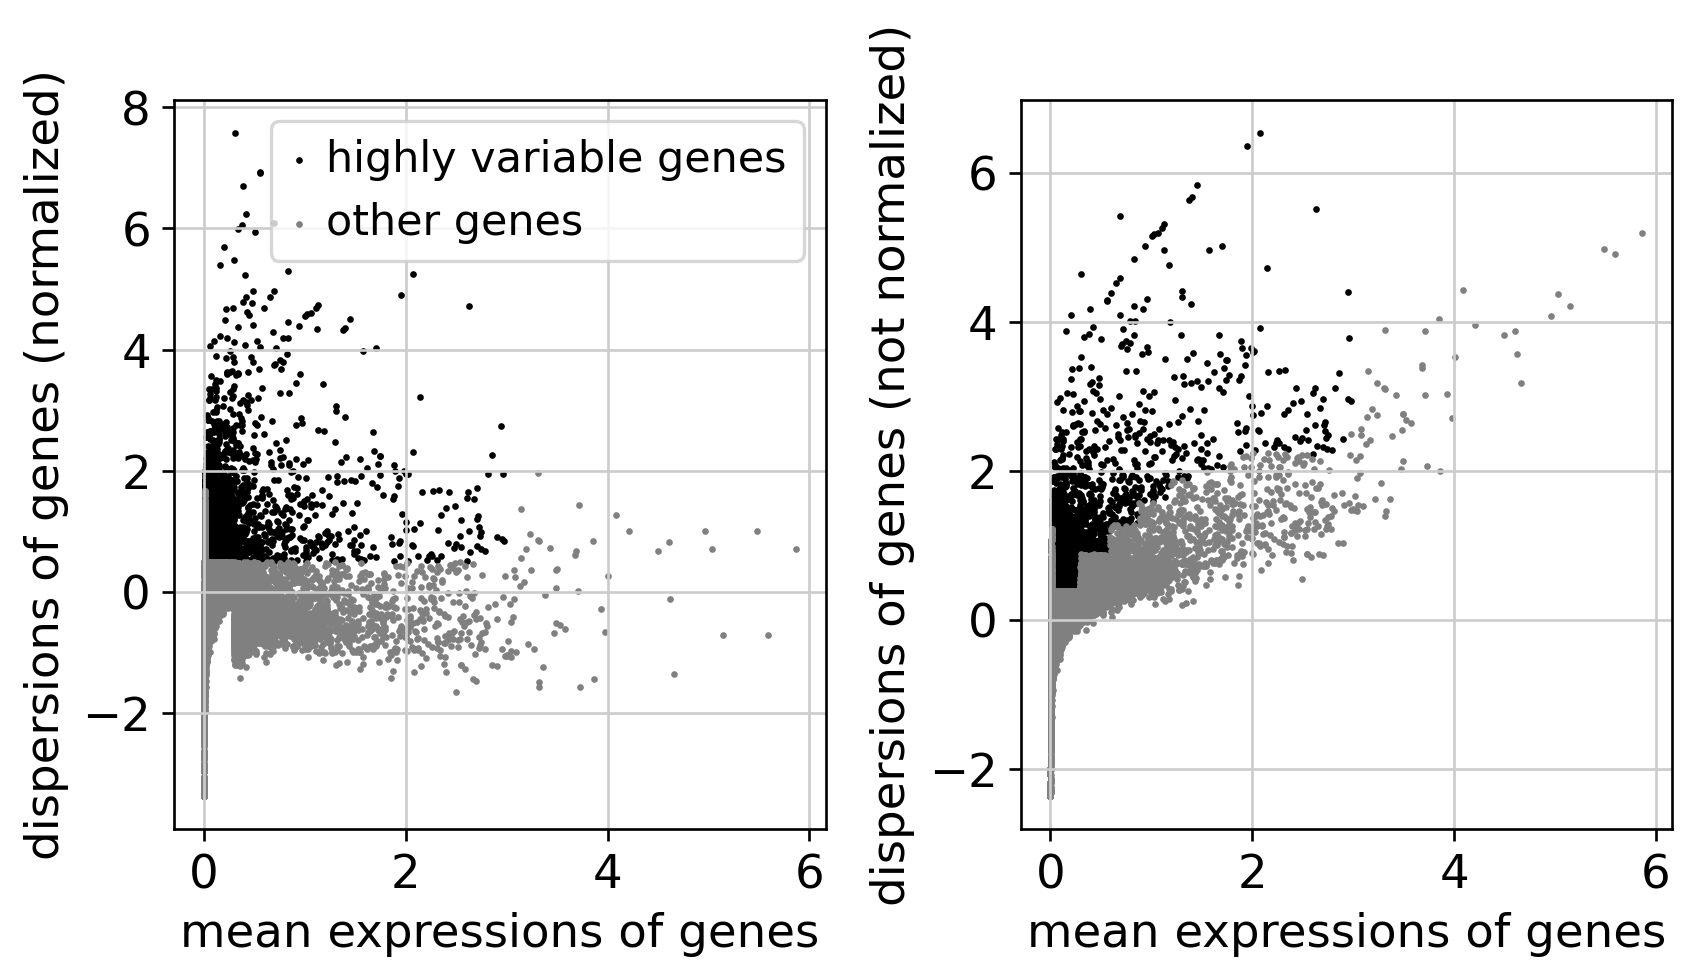

In [ ]:
sc.pl.highly_variable_genes(adata_R)

In [ ]:

sc.pp.scale(adata_R, max_value=10)
# PCA on highly variable genes
sc.tl.pca(adata_R, svd_solver='arpack', use_highly_variable=True)


    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)


In [ ]:
sc.pp.neighbors(adata_R, n_neighbors = 20, n_pcs=8) # n_neigh 60, n_pcs 50 ; n_neighbors = 60, n_pcs=20, 15, 10

sc.tl.umap(adata_R, min_dist=0.01) # min_dist 0.05
sc.tl.diffmap(adata_R)

sc.tl.leiden(adata_R, resolution=1, )

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.981396   0.9269981  0.9102421  0.89339983 0.8575542
     0.81773674 0.786535   0.7816292  0.7498398  0.7257154  0.6601269
     0.65358377 0.6354536  0.6143875 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


### Annotate clusters

In [ ]:
# Manualy annotate RSL2+ cells as seperate cluster
ind = np.ndarray.flatten(adata_R[:,'Mp6g21470'].X > -0.100378916)
adata_R.obs['clusters'] = np.where(ind, '7', adata_R.obs['leiden'].astype('object'))

adata_R.obs['clusters'] = adata_R.obs['clusters'].astype('category')

# Rename clusters
adata_R.obs['clusters'].cat.categories = ['Rhizoid precursor 1', 'Committed precursor', 'Rhizoid precursor 2', 'Elongating Rhizoid', 'Mature Rhizoid 1', 'Rhizoid precursor 3', 'Mature Rhizoid 2', 'Mucilage Cell']

# Reorder clusters
adata_R.obs['clusters']=pd.Series(pd.Categorical(adata_R.obs['clusters'], 
                                                  categories=['Rhizoid precursor 1',  'Rhizoid precursor 2', 'Rhizoid precursor 3',  'Committed precursor','Elongating Rhizoid', 'Mature Rhizoid 1', 'Mature Rhizoid 2', 'Mucilage Cell']),
                                   index=adata_R.obs_names)

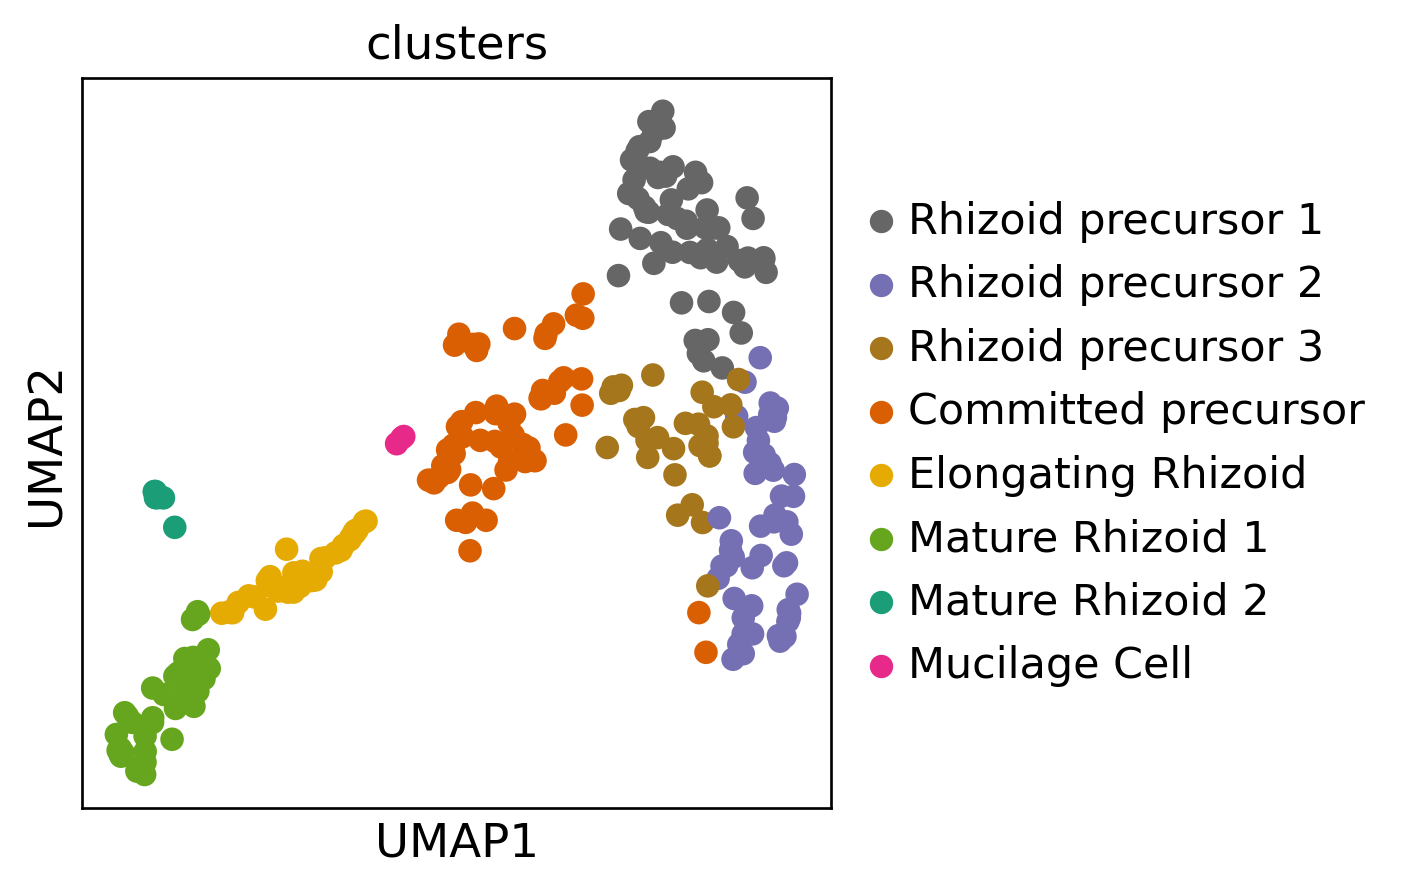

In [ ]:
sc.pl.umap(adata_R, color=['clusters'],palette=['#666666', '#7570b3', '#a6761d', '#d95f02','#e6ab02', '#66a61e','#1b9e77','#e7298a'],  size=200, save="_R.pdf")

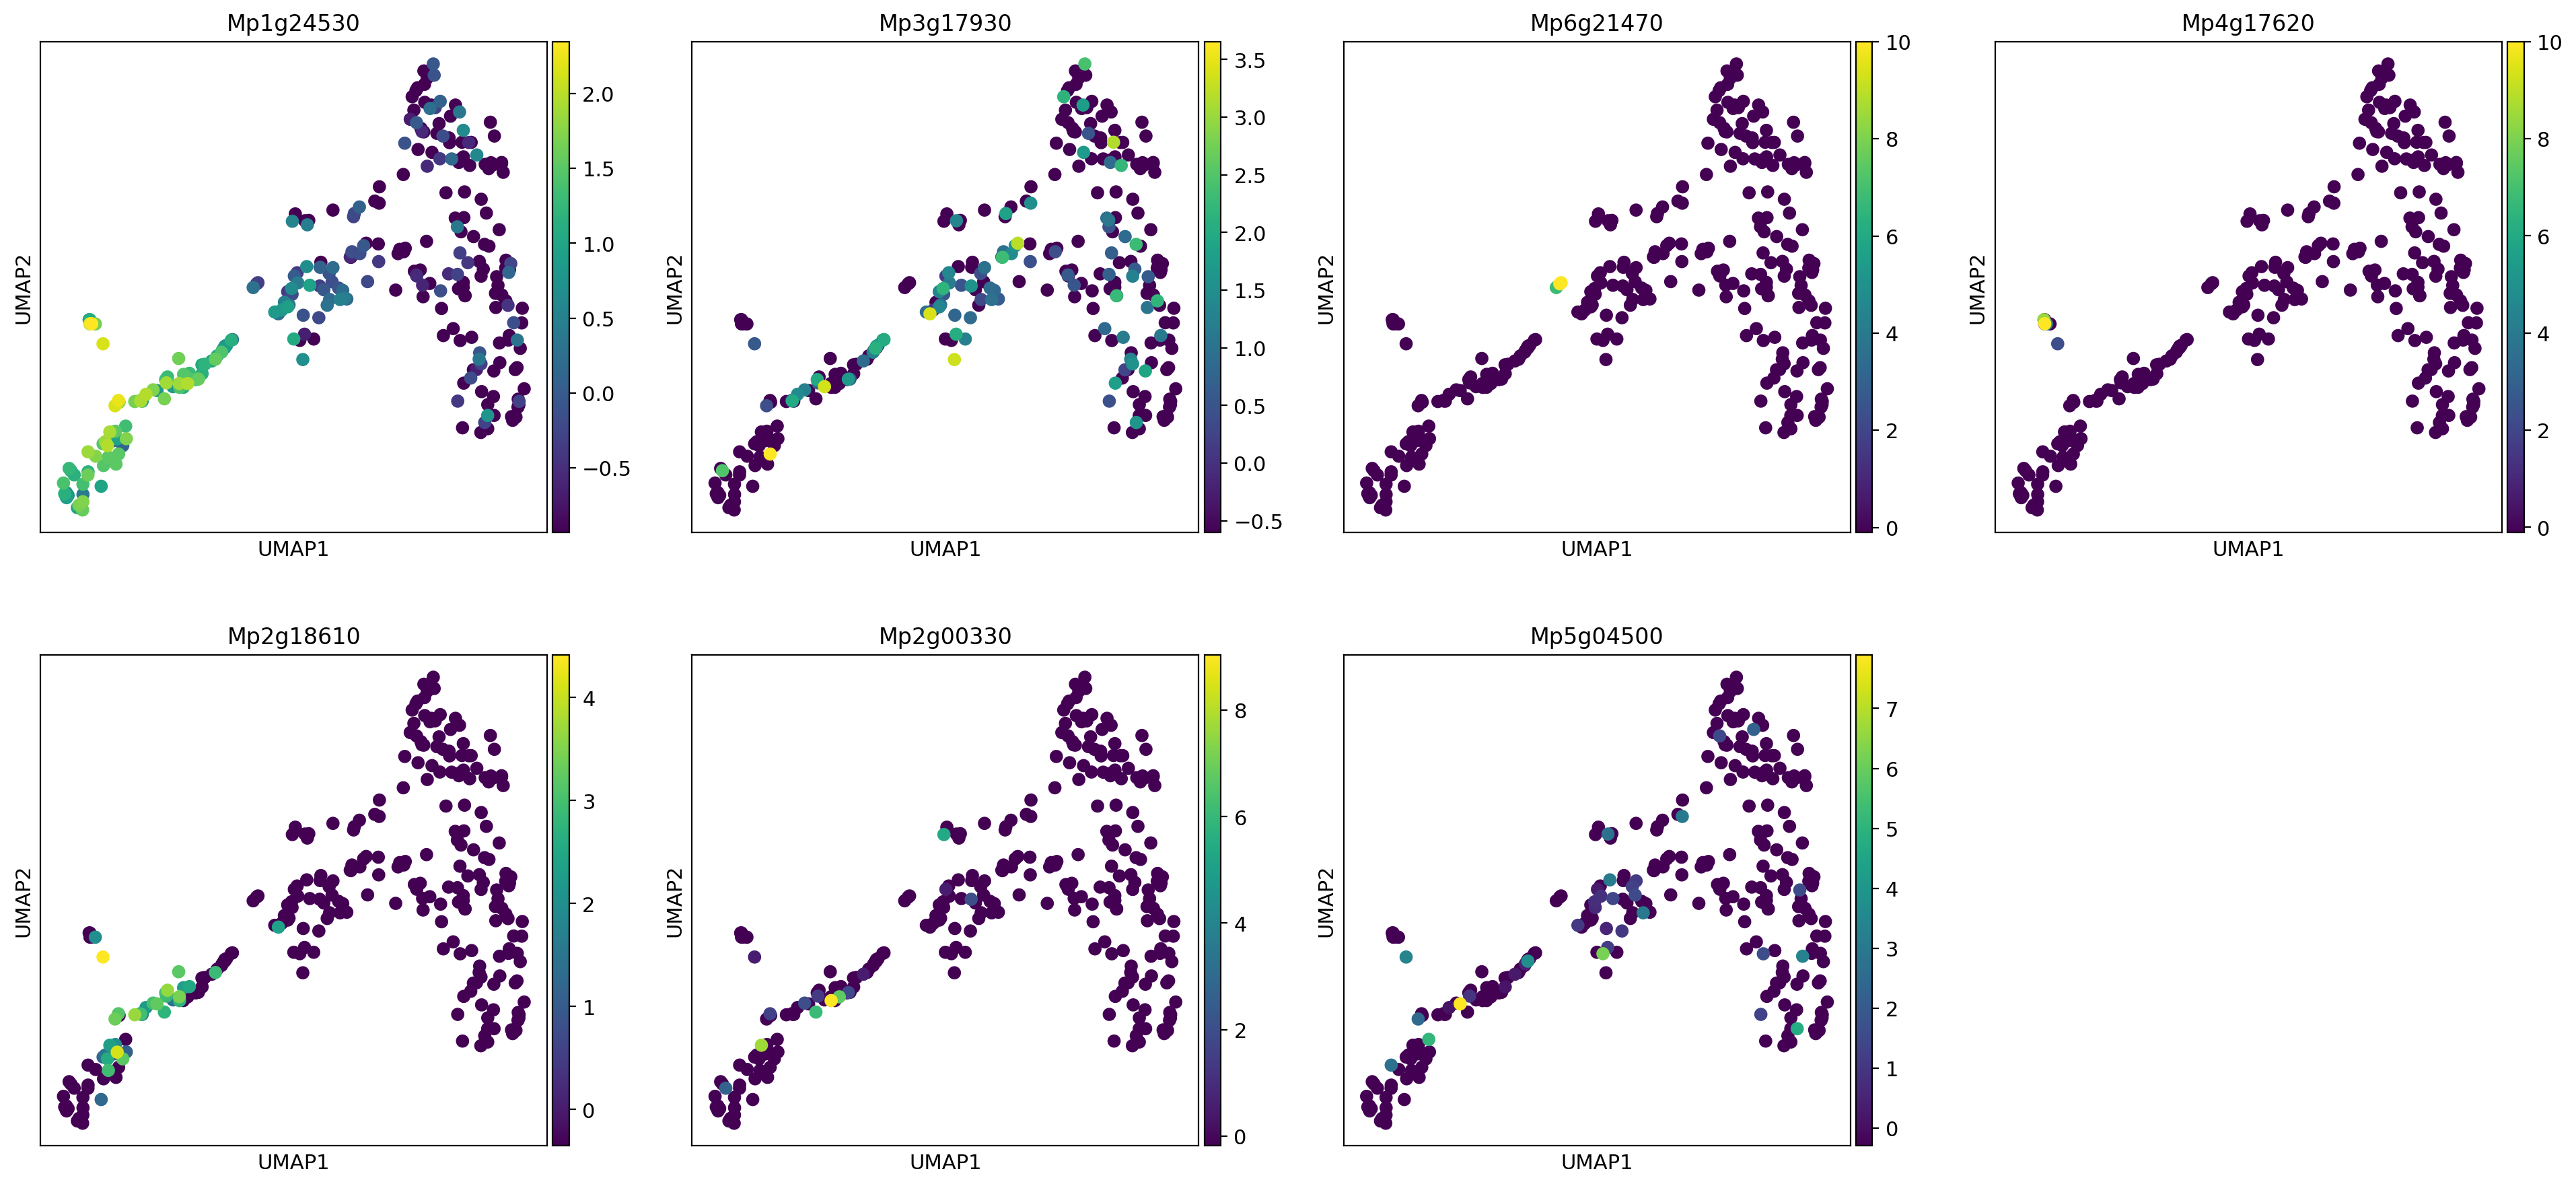

In [ ]:

sc.pl.umap(adata_R, color=['Mp1g24530', 'Mp3g17930', 'Mp6g21470',  'Mp4g17620', 'Mp2g18610', 'Mp2g00330', 'Mp5g04500'], size=200, save="_R_markers.pdf", color_map='viridis')

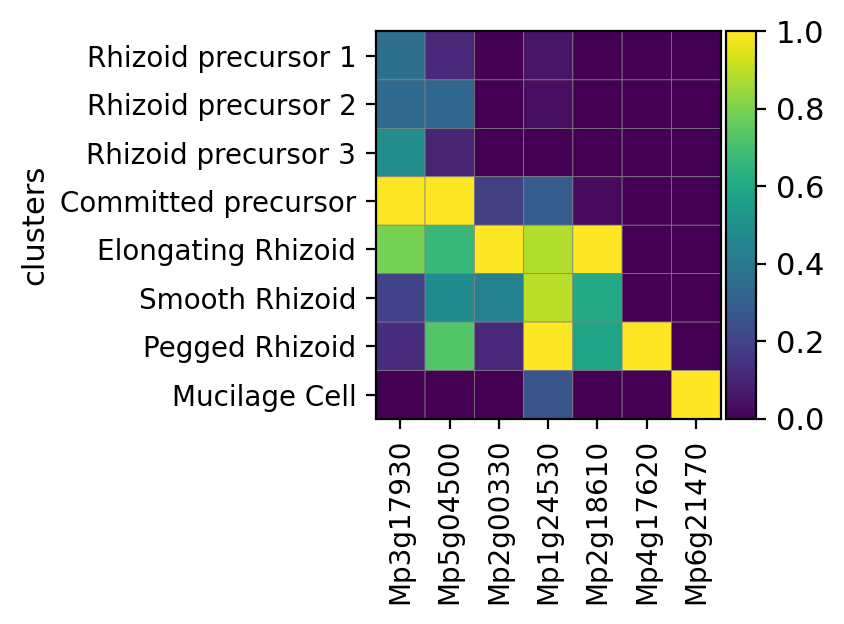

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[2.24, 0, 0.2])

In [ ]:
sc.pl.matrixplot(adata_R, var_names=['Mp3g17930',  'Mp5g04500','Mp2g00330','Mp1g24530', 'Mp2g18610',   'Mp4g17620', 'Mp6g21470'], groupby='clusters', standard_scale='var', cmap='viridis', save="_R_markers.pdf")

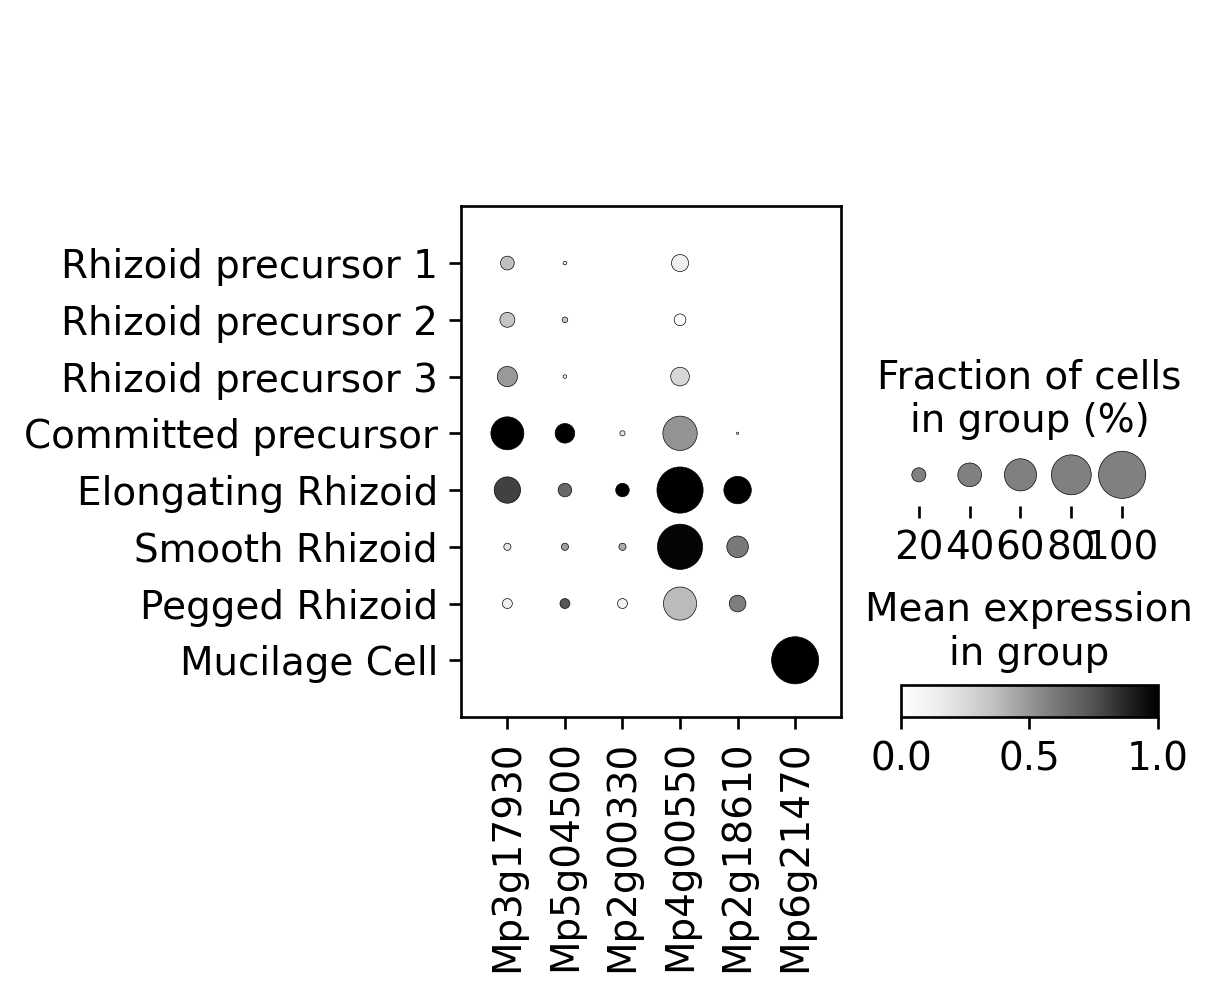

In [ ]:
sc.pl.dotplot(adata_R, var_names=['Mp3g17930',  'Mp5g04500','Mp2g00330','Mp4g00550', 'Mp2g18610',  'Mp6g21470'], groupby='clusters', standard_scale='var',cmap='Greys', save="R_markers_bw.pdf")

### Biological process

In [ ]:
apoptosis_genes = {'senescence': ['Mp5g16540','Mp2g26270','Mp5g00240' ,'Mp3g08200'], 
                     'apoptosis promoting': ['Mp3g24240','Mp4g14400','Mp6g02940', 'Mp5g11730', 'Mp7g17040', 'Mp8g07700', 'Mp1g10220','Mp1g21200', 'Mp1g12500', 'Mp2g25760', 'Mp4g02860'], 
                   'apoptosis inhibiting': ['Mp4g22500', 'Mp5g11450', 'Mp5g14280']}

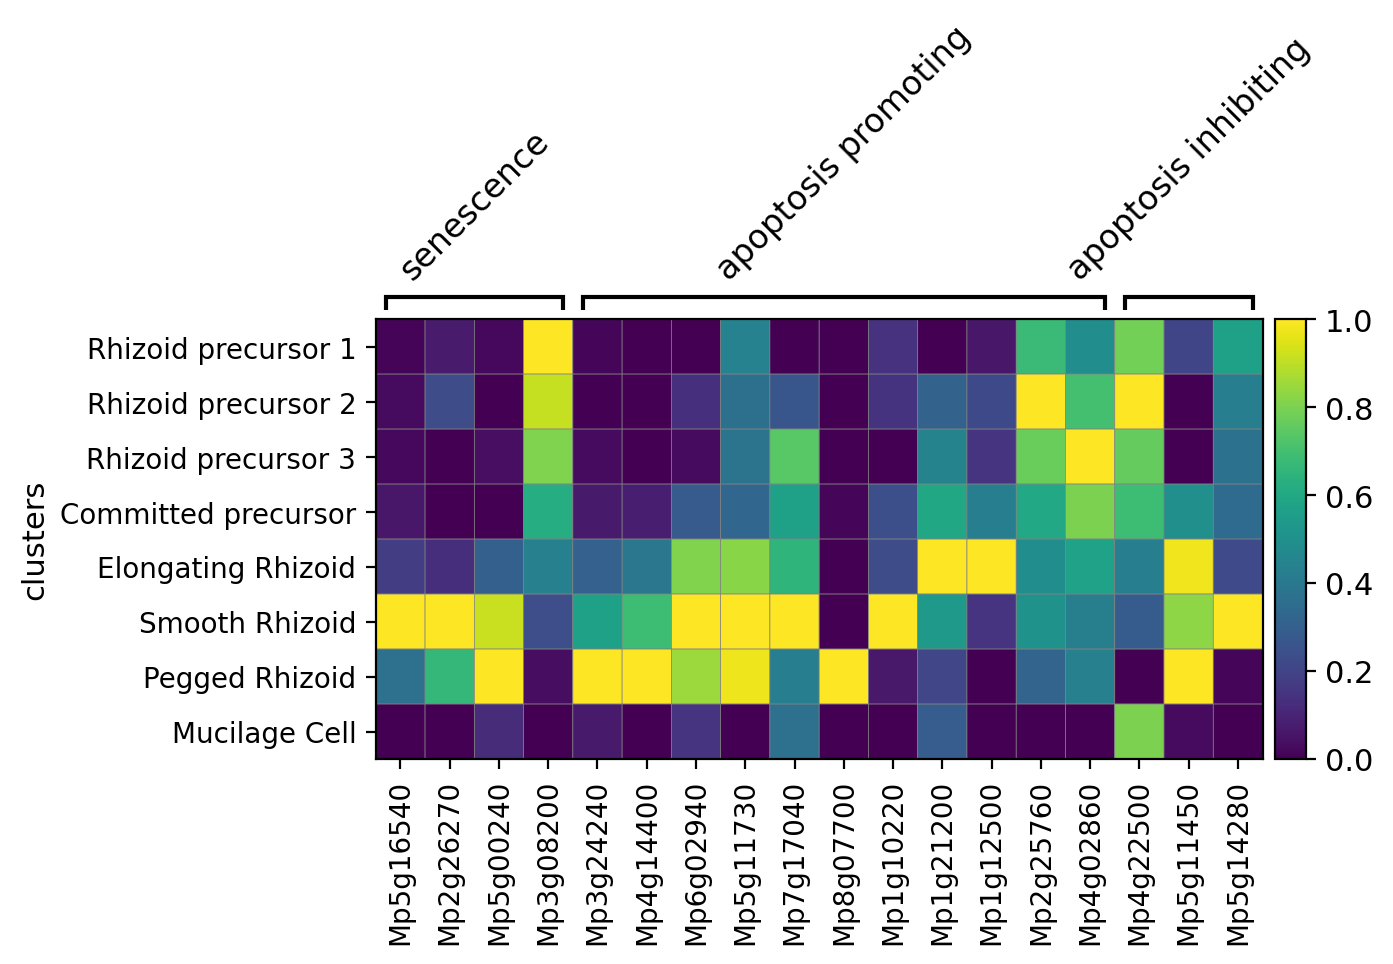

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[5.76, 0, 0.2])

In [ ]:
sc.pl.matrixplot(adata_R, apoptosis_genes, groupby='clusters', standard_scale='var', cmap='viridis', save="_R_apoptosis.pdf", var_group_rotation=45)

In [ ]:
gene_func = pd.read_table('../genome/annotation/5.1_gene_function_from_3.1.txt')

photosynthesis = gene_func[gene_func['annot_ID'].isin(['GO:0015979'])]['5.1_ID']
cell_wall = gene_func[gene_func['annot_ID'].isin(['GO:0005618'])]['5.1_ID']

sc.tl.score_genes(adata_R, gene_list = photosynthesis, score_name="Photosynthesis")
sc.tl.score_genes(adata_R, gene_list = cell_wall, score_name="Cell_wall")

computing score 'Photosynthesis'
    finished: added
    'Photosynthesis', score of gene set (adata.obs).
    798 total control genes are used. (0:00:00)
computing score 'Cell_wall'
    finished: added
    'Cell_wall', score of gene set (adata.obs).
    897 total control genes are used. (0:00:00)


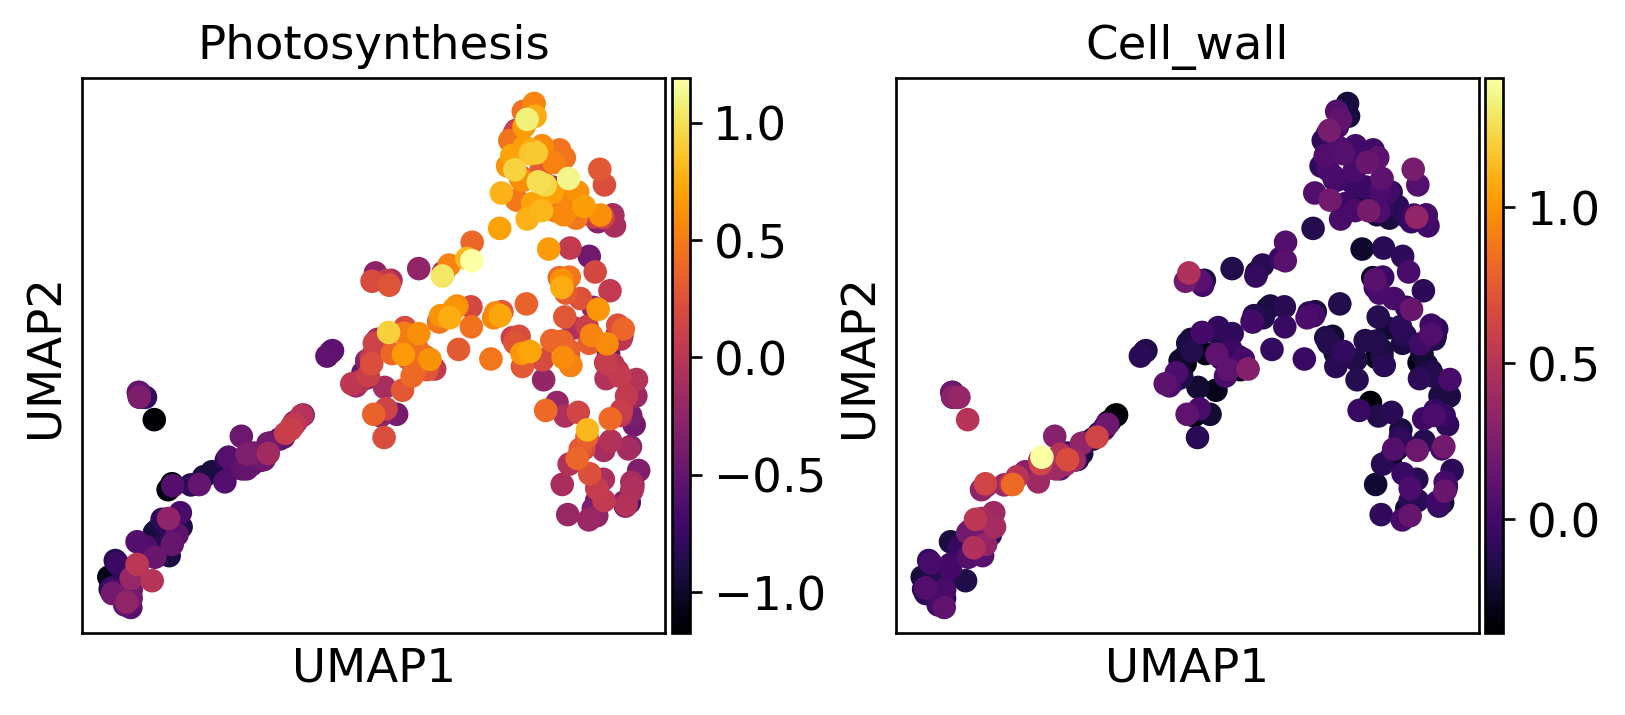

In [ ]:
sc.settings.set_figure_params(figsize=(3,3), dpi=120)
sc.pl.umap(adata_R, color=['Photosynthesis', 'Cell_wall'], color_map='inferno', size=200)
sc.settings.set_figure_params(figsize=None, dpi=120)


In [ ]:
 sc.tl.rank_genes_groups(adata_R, groupby='clusters', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


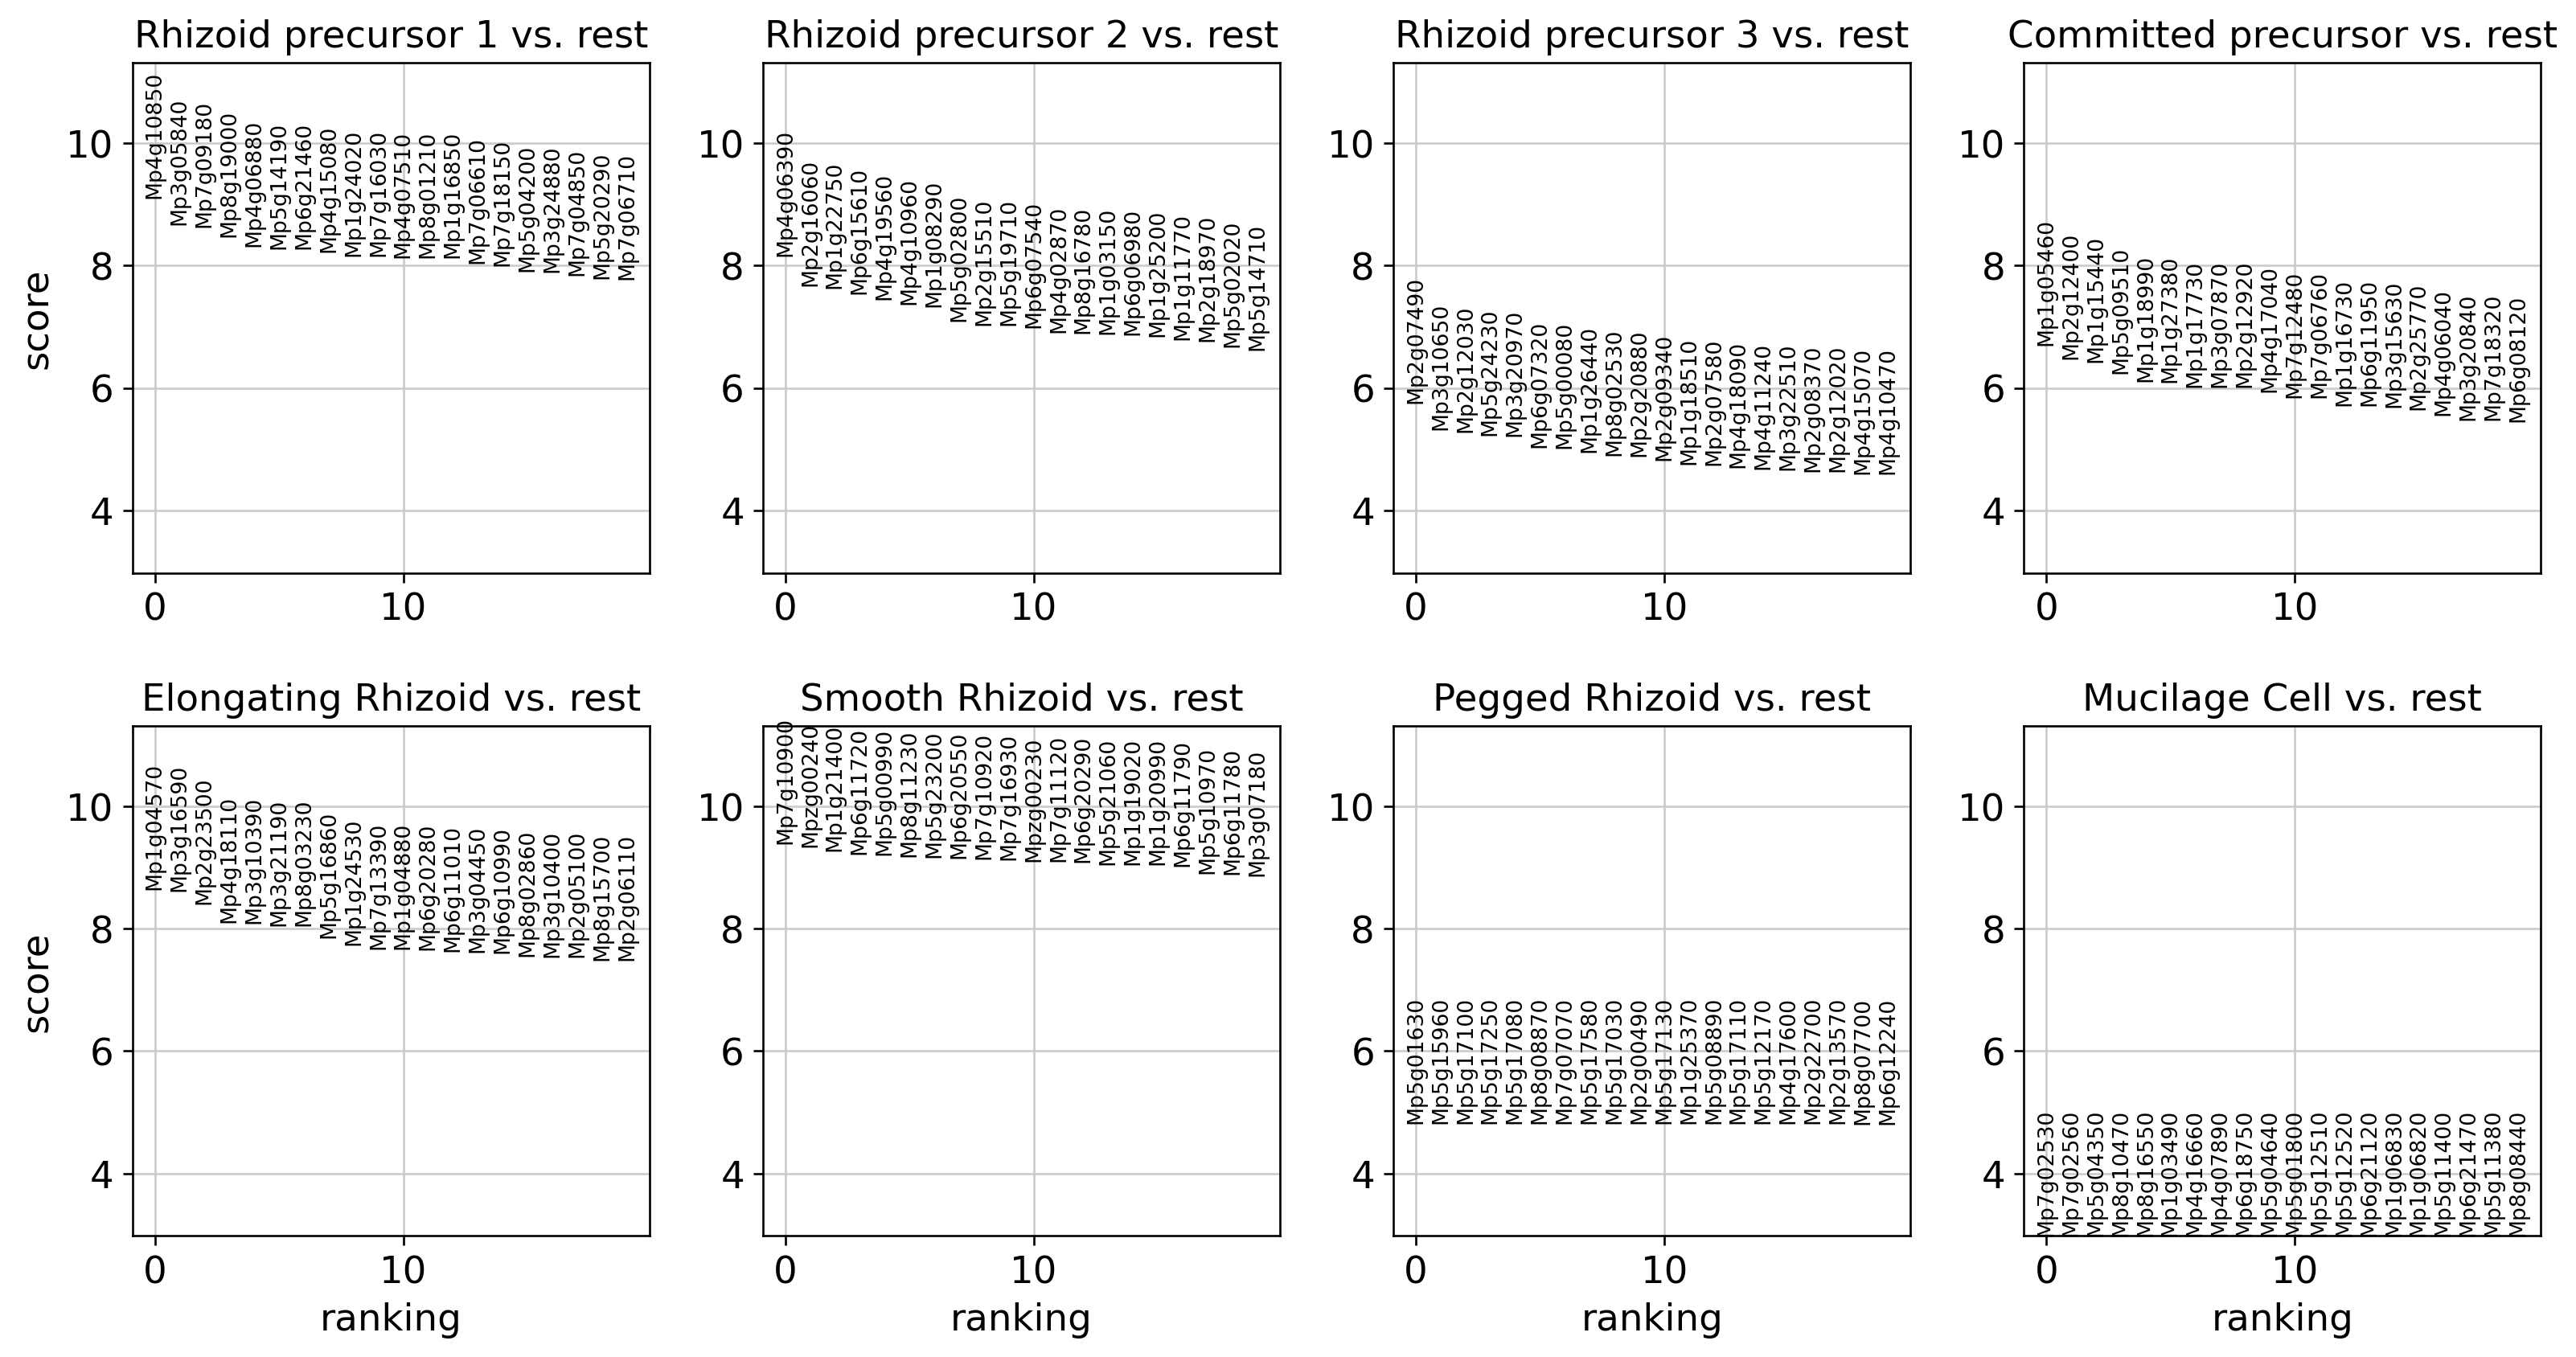

In [ ]:
sc.pl.rank_genes_groups(adata_R)

In [ ]:
pd.DataFrame.from_records(adata_R.uns['rank_genes_groups']['names'])[1:101].to_csv('R_wilcox.csv')

### Save/Read

In [ ]:
adata_R.write("5.1_R_only.h5ad")
umap = adata_R.obsm["X_umap"]
np.savetxt("umap_R.csv", umap, delimiter=",")
pd.DataFrame(adata_R.obs).to_csv("obs_R.txt", header=True, index=True)
pd.DataFrame(adata_R.var).to_csv("var_R.txt", header=True, index=True)

pd.DataFrame(adata_R.obs.index).to_csv("barcodes_R.txt", header=False, index=False)
pd.DataFrame(adata_R.var.index).to_csv("genes_R.txt", header=False, index=False)


In [ ]:
adata_R = anndata.read_h5ad("5.1_R_only.h5ad")
adata_R

AnnData object with n_obs × n_vars = 287 × 16682
    obs: 'n_genes', 'n_counts', 'leiden', 'clusters', 'dpt_pseudotime'
    var: 'gene', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'clusters_sizes', 'diffmap_evals', 'iroot', 'leiden', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
adata_R.write("5.1_R_only_2021.h5ad")

## RNA velocity

### Create adata object

Read in spliced/unspiced files

In [ ]:
scv.set_figure_params('scvelo')  # for beautified visualization
scv.set_figure_params(figsize=[5,5])

In [ ]:
s = sc.read_mtx("../velo_tak_51/counts_unfiltered/spliced.mtx")
u = sc.read_mtx("../velo_tak_51/counts_unfiltered/unspliced.mtx")

s_brc = pd.read_csv("../velo_tak_51/counts_unfiltered/spliced.barcodes.txt", header=None)
u_brc = pd.read_csv("../velo_tak_51/counts_unfiltered/unspliced.barcodes.txt", header=None)

genes = pd.read_csv("../velo_tak_51/counts_unfiltered/spliced.genes.txt", header=None)

s.obs.index = s_brc[0].values
u.obs.index = u_brc[0].values

s.var.index = genes[0].values
u.var.index = genes[0].values

Filter based on previous barcode list 

In [ ]:
brc_f = pd.read_csv("barcodes_R.txt", header=None)
genes_f = pd.read_csv("genes_R.txt", header=None)


s = s[s.obs.index.isin(brc_f[0].values),:]
u = u[u.obs.index.isin(brc_f[0].values),:]

In [ ]:
adata = s.copy()

adata.layers["spliced"] = s.X
adata.layers["unspliced"] = u.X
adata.layers["ambiguous"] = scp.sparse.csr_matrix(np.zeros(adata.X.shape))

adata.obs = s.obs

scv.pp.show_proportions(adata)

Abundance of ['spliced', 'unspliced']: [0.96 0.04]


In [ ]:
t2g = pd.read_csv("../index/t2g.txt", header=None, names=["tid", "gene_id", "gene_name", "NA", "chr", "start", "end", "strand"], sep="\t")
t2g.index = t2g.gene_id
t2g.gene_name = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_id"] = adata.var.index
adata.obs["cell_id"] = adata.obs.index # doesn't work, why?

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_id"])
adata.var.index = adata.var["gene_name"]

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

Trying to set attribute `.obs` of view, copying.


In [ ]:
adata.write_loom("./Mp_51_R.loom")

### Run Velocyto pipeline

Import previous UMAP and leiden clustering

In [ ]:
obs =  pd.read_csv("obs_R.txt")

In [ ]:
adata = scv.read_loom("./Mp_51_R.loom")

In [ ]:
pd.Categorical(np.asarray(obs.clusters))

['Smooth Rhizoid', 'Rhizoid precursor 2', 'Rhizoid precursor 2', 'Pegged Rhizoid', 'Smooth Rhizoid', ..., 'Rhizoid precursor 1', 'Committed precursor', 'Smooth Rhizoid', 'Rhizoid precursor 2', 'Smooth Rhizoid']
Length: 287
Categories (8, object): ['Committed precursor', 'Elongating Rhizoid', 'Mucilage Cell', 'Pegged Rhizoid',
                         'Rhizoid precursor 1', 'Rhizoid precursor 2', 'Rhizoid precursor 3',
                         'Smooth Rhizoid']

In [ ]:
adata.obsm["X_umap"] = np.genfromtxt("umap_R.csv", delimiter=',')

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=10) # 10 and 3000 was good, n_top_genes=3000

Filtered out 20343 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [ ]:
scv.pp.moments(adata) # 30 and 10 worked well

computing PCA
    with n_comps=30
    finished (0:00:00)
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')

recovering dynamics (using 1/2 cores)



    finished (0:00:08) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [ ]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
adata.obs['clusters'] = pd.Categorical(np.asarray(obs.clusters))
# Reorder clusters
adata.obs['clusters']=pd.Series(pd.Categorical(adata.obs['clusters'], 
                                                  categories=['Rhizoid precursor 1',  'Rhizoid precursor 2', 'Rhizoid precursor 3',  'Committed precursor','Elongating Rhizoid', 'Smooth Rhizoid', 'Pegged Rhizoid', 'Mucilage Cell']),
                                   index=adata.obs_names)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


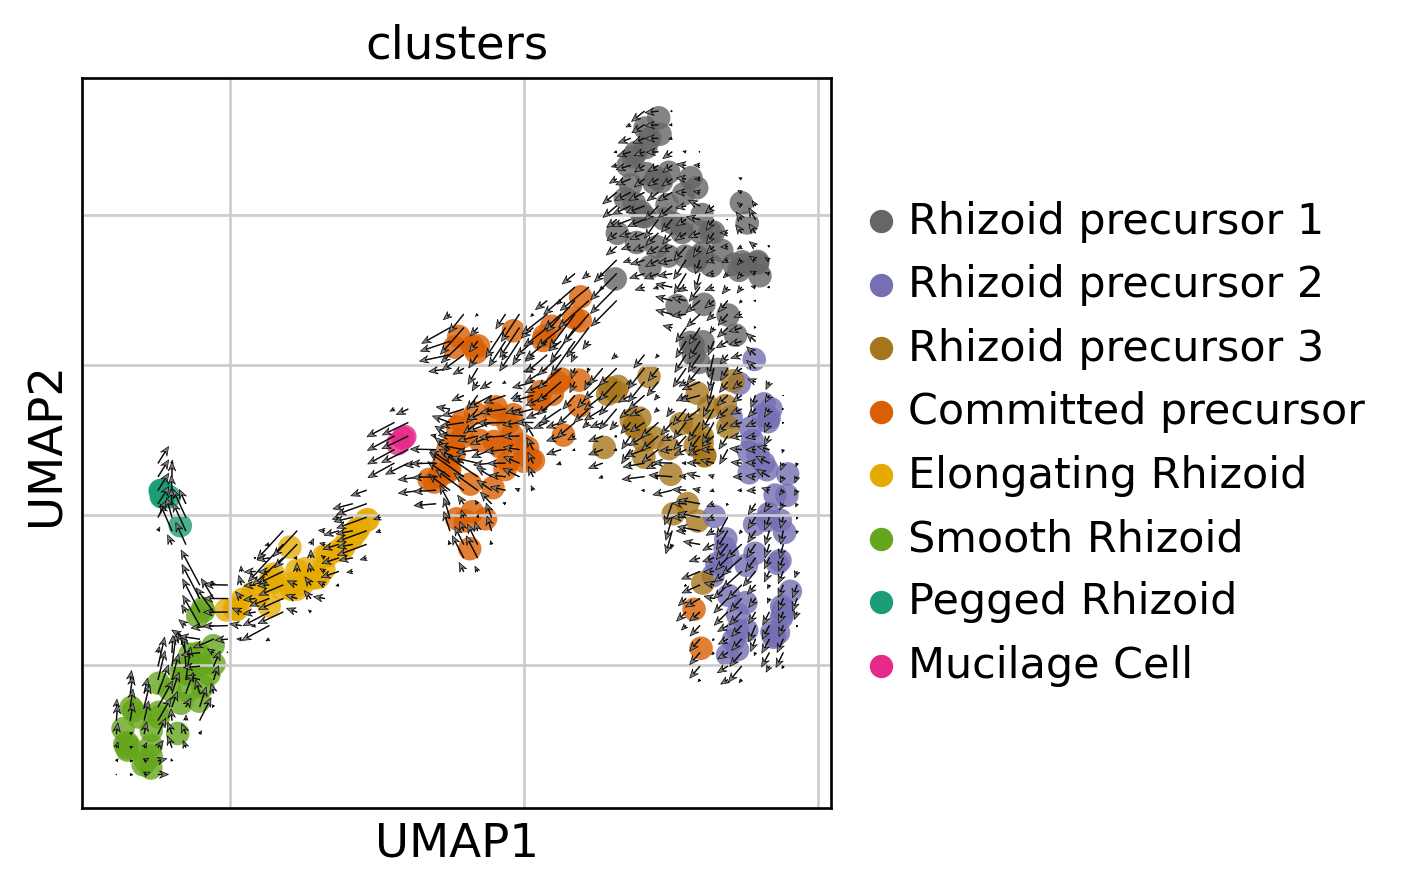

In [ ]:

scv.pl.velocity_embedding_grid(adata, basis='umap', size=200, color='clusters', frameon=True, legend_loc='right', 
                               palette=['#666666', '#7570b3', '#a6761d', '#d95f02','#e6ab02', '#66a61e','#1b9e77','#e7298a'], alpha=0.8, arrow_size=2,figsize=[4,4], arrow_length=2) #save='R_vel_grid.pdf'

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


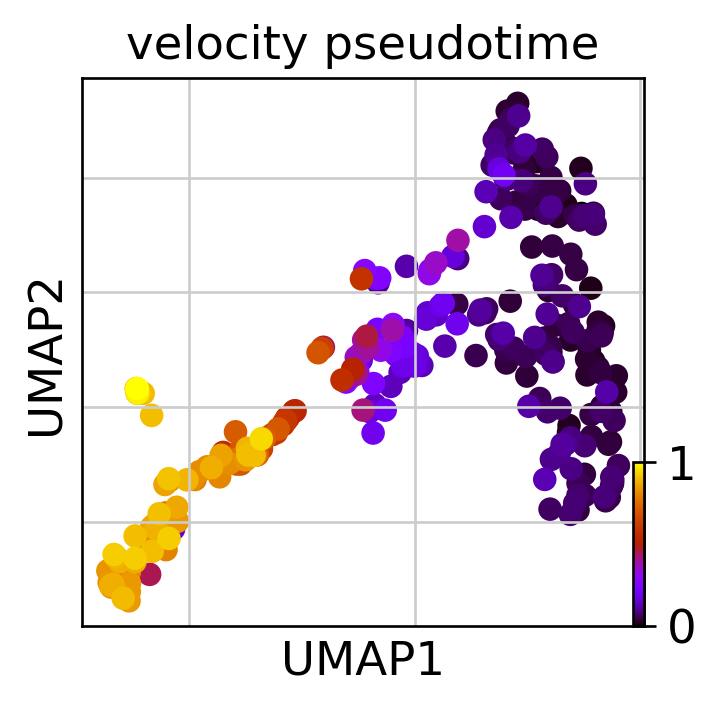

In [ ]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', size=200, frameon=True, figsize=[3,3])#, save='R_vel_time.pdf'

saving figure to file ./figures/scvelo_R_vel_time_grid.pdf


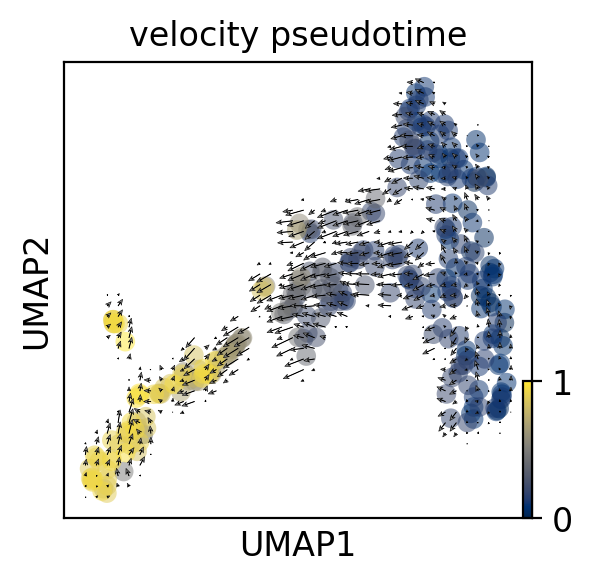

In [ ]:
scv.pl.velocity_embedding_grid(adata, basis='umap', size=200, color='velocity_pseudotime',  cmap='cividis', frameon=True, legend_loc='right', alpha=0.5, arrow_size=2,figsize=[3,3], arrow_length=1.5,  density=0.8, save='R_vel_time_grid.pdf')

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


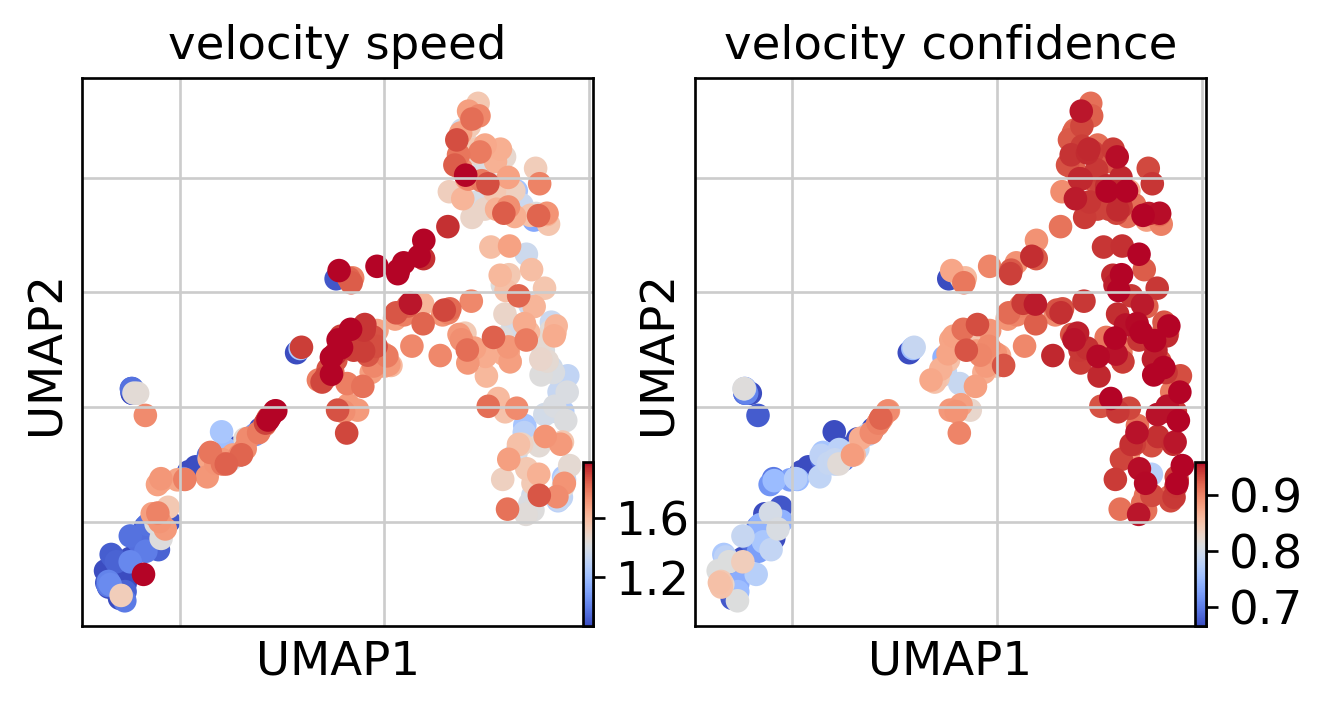

In [ ]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], size=200, title=['velocity_speed', 'velocity_confidence'], frameon=True,figsize=[3,3], save='R_vel_conf.pdf')

In [ ]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='clusters', minimum_spanning_tree=False)


computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


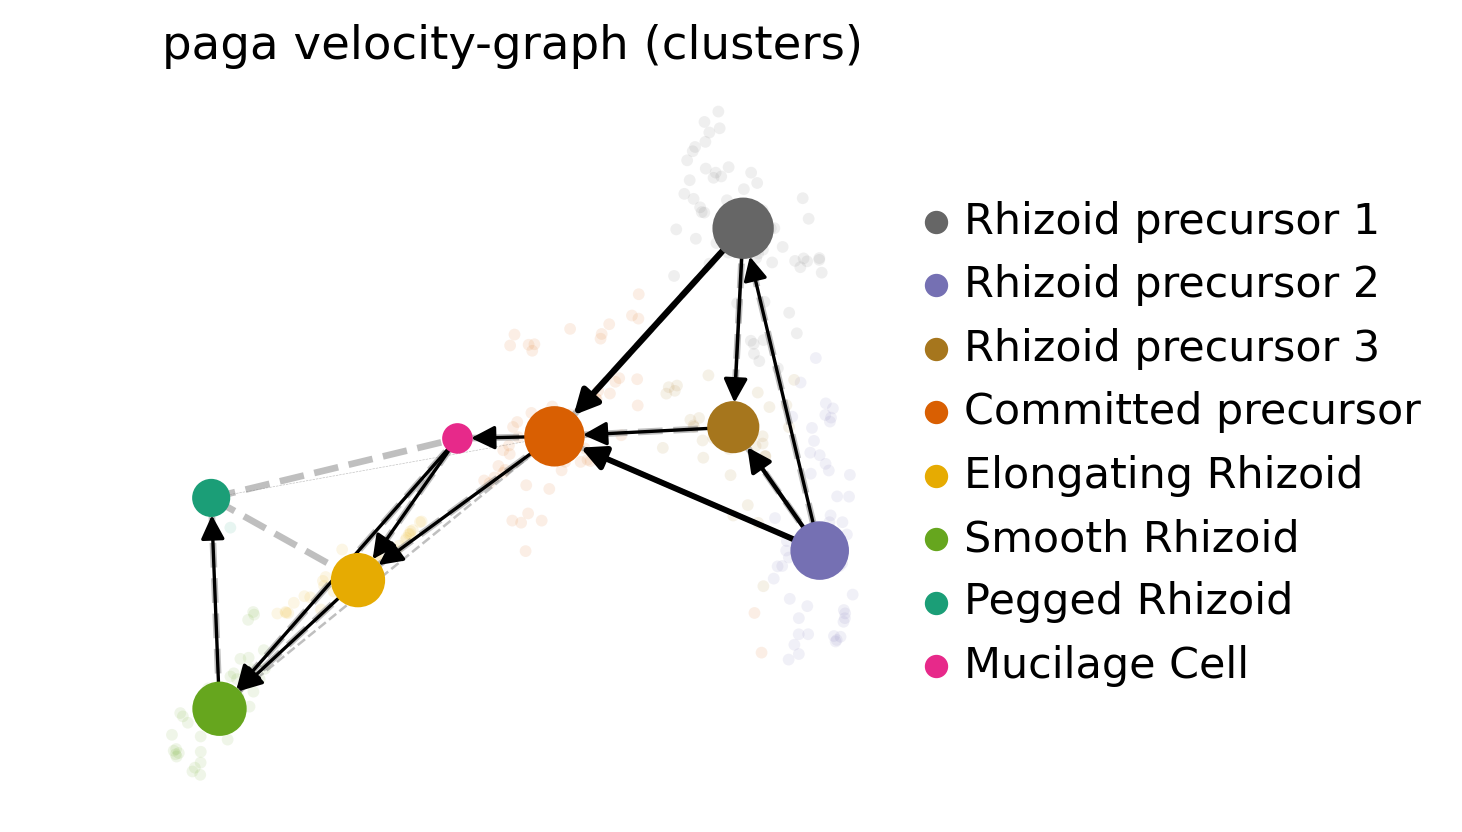

In [ ]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=1, node_size_scale=1.5)# save='paga_R.pdf'

## Plot pseudotime genes

In [ ]:
adata.obs.index = adata.obs['obs_names']
adata_R.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime']

In [ ]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:100]

saving figure to file ./figures/scvelo_heatmap_R_dpt_pseudotime_photosynthesis.pdf


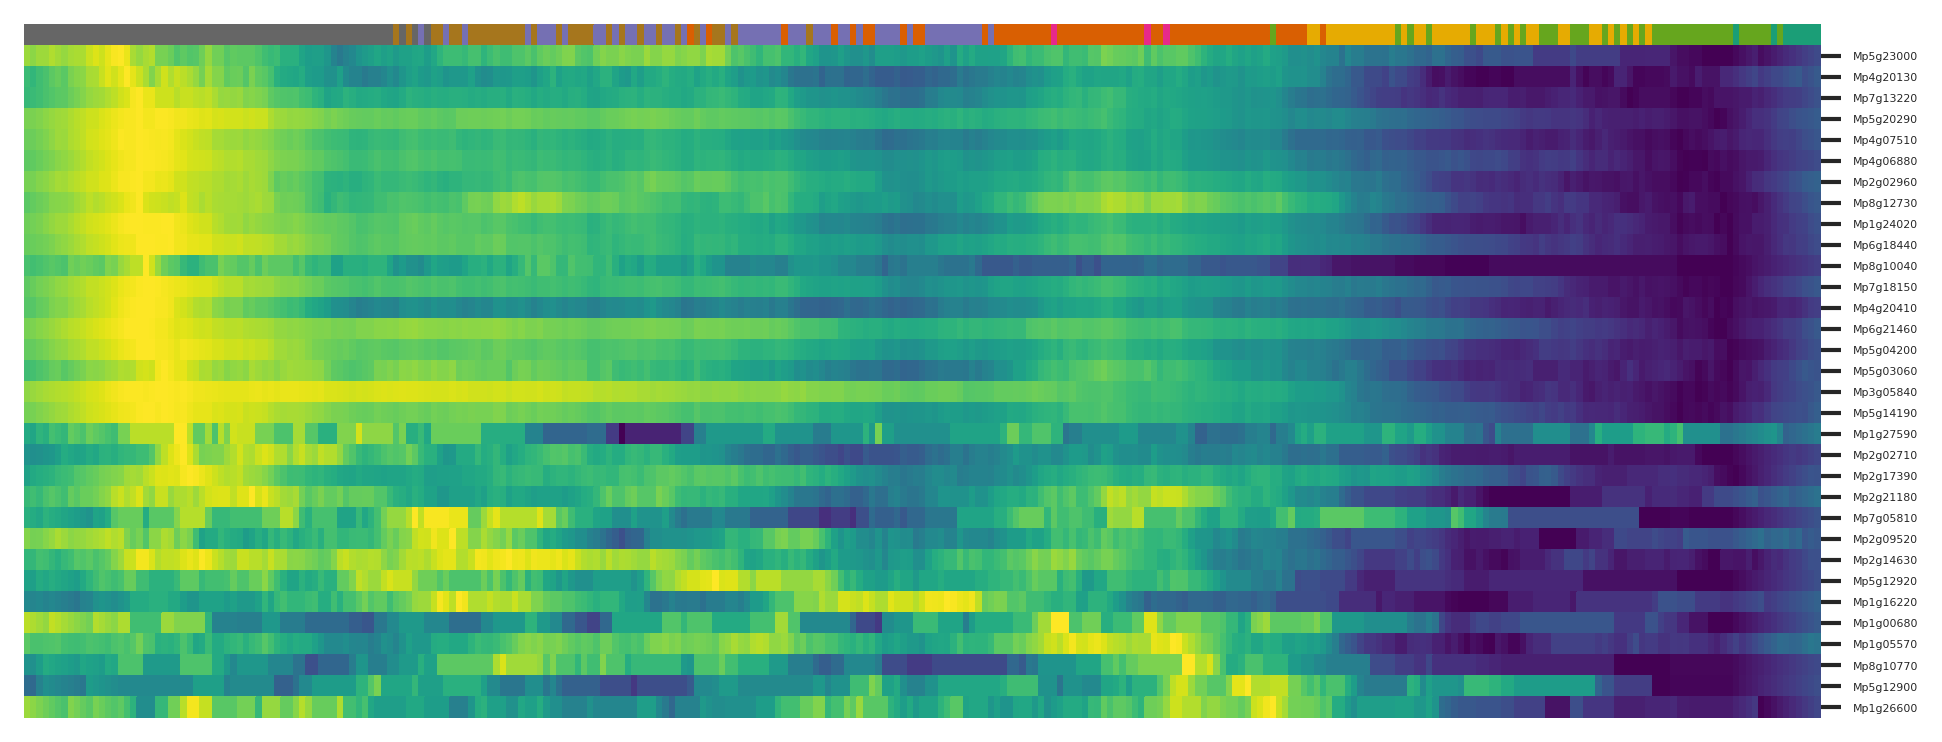

In [ ]:

scv.pl.heatmap(adata_R, var_names=photosynthesis, sortby='dpt_pseudotime', col_color='clusters', figsize=(8,3), font_scale=0.3, save='R_dpt_pseudotime_photosynthesis')

saving figure to file ./figures/scvelo_heatmap_R_dpt_pseudotime_cell_wall.pdf


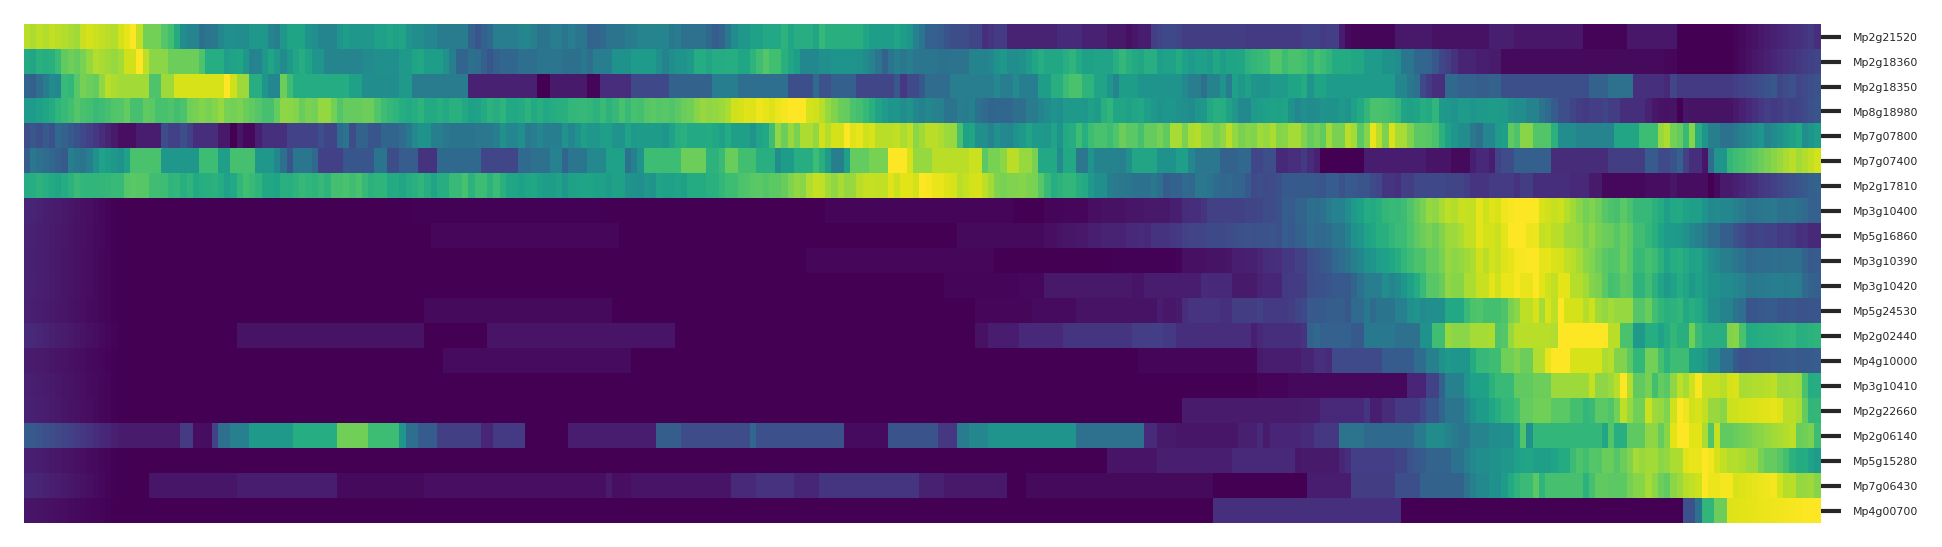

In [ ]:

scv.pl.heatmap(adata_R, var_names=cell_wall, sortby='dpt_pseudotime', figsize=(8,(len(cell_wall)/len(photosynthesis))*3.5), font_scale=0.3, save='R_dpt_pseudotime_cell_wall')

saving figure to file ./figures/scvelo_heatmap_R_dpt_pseudotime_expansin.pdf


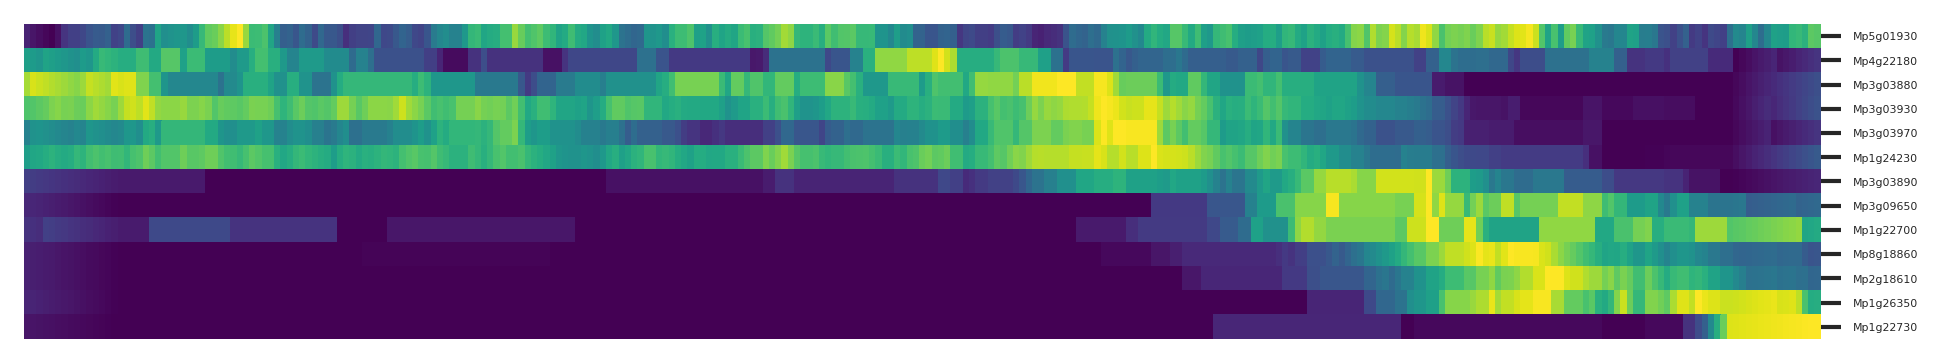

In [ ]:
scv.pl.heatmap(adata_R, var_names=expansin, sortby='dpt_pseudotime', figsize=(8,(len(expansin)/len(photosynthesis))*3.5), font_scale=0.3, save='R_dpt_pseudotime_expansin')

saving figure to file ./figures/scvelo_heatmap_R_dpt_pseudotime_cytoskeleton.pdf


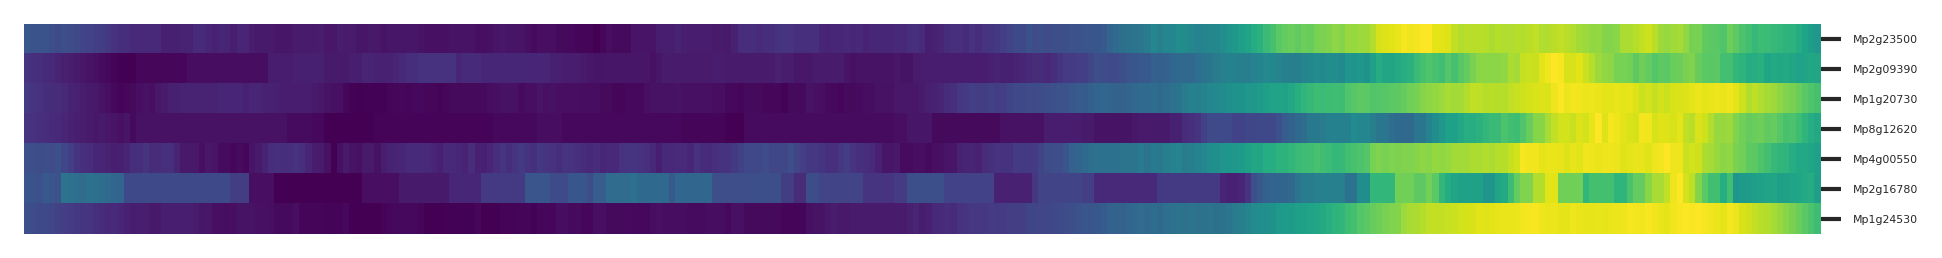

In [ ]:
scv.pl.heatmap(adata_R, var_names=cytoskeleton, sortby='dpt_pseudotime', figsize=(8,(len(cytoskeleton)/len(photosynthesis))*4.5),font_scale=0.3, save='R_dpt_pseudotime_cytoskeleton')

saving figure to file ./figures/scvelo_heatmap_R_dpt_pseudotime_auxin.pdf


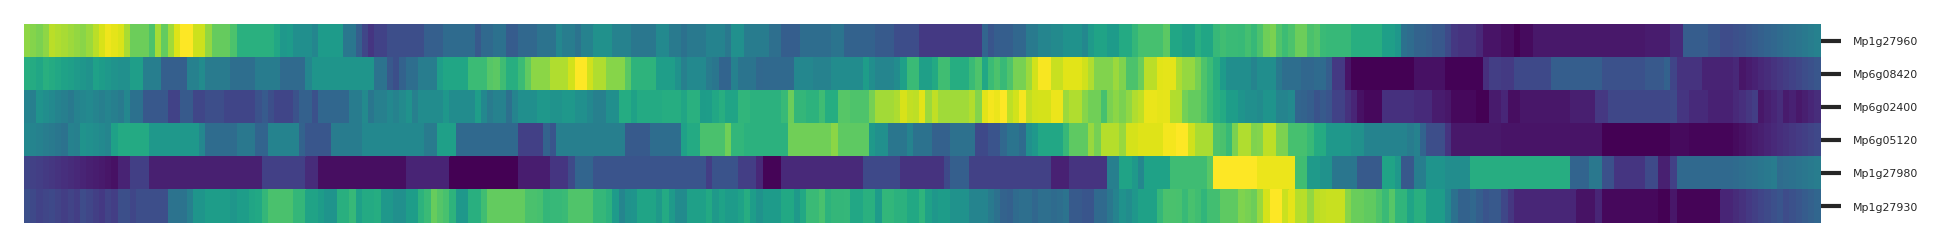

In [ ]:
scv.pl.heatmap(adata_R, var_names=auxin_response, sortby='dpt_pseudotime', figsize=(8,(len(auxin_response)/len(photosynthesis))*5), font_scale=0.3, save='R_dpt_pseudotime_auxin')

In [ ]:
#gene_func = pd.read_table('../genome/annotation/5.1_gene_function_from_3.1.txt')

gene_func = pd.read_table('../genome/annotation/MpTak_v6.1_func_annotation.tsv')

photosynthesis = gene_func[gene_func['ref_id'].isin(['GO:0015979'])]['gene_id'].str.split('.').str[0].drop_duplicates()
photosynthesis = photosynthesis[photosynthesis.isin(adata_R[:,adata_R.var['means'] > 0.1].var['gene_name'])]
cell_wall = gene_func[gene_func['ref_id'].isin(['GO:0042546', 'GO:0030244'])]['gene_id'].str.split('.').str[0].drop_duplicates()
cell_wall = cell_wall[cell_wall.isin(adata_R[:,adata_R.var['means'] > 0.1].var['gene_name'])]
expansin = gene_func[gene_func['ref_id'].isin(['PR01226'])]['gene_id'].str.split('.').str[0].drop_duplicates()
expansin = expansin[expansin.isin(adata_R[:,adata_R.var['means'] > 0.1].var['gene_name'])]
cytoskeleton = gene_func[gene_func['ref_id'].isin(['GO:0005200'])]['gene_id'].str.split('.').str[0].drop_duplicates()
cytoskeleton = cytoskeleton[cytoskeleton.isin(adata_R[:,adata_R.var['means'] > 0.1].var['gene_name'])]
auxin_response = gene_func[gene_func['ref_id'].isin(['PF02519'])]['gene_id'].str.split('.').str[0].drop_duplicates()
auxin_response = auxin_response[auxin_response.isin(adata_R[:,adata_R.var['means'] > 0.1].var['gene_name'])]


sc.tl.score_genes(adata_R, gene_list = photosynthesis, score_name="Photosynthesis")
sc.tl.score_genes(adata_R, gene_list = cell_wall, score_name="Cell_wall")
sc.tl.score_genes(adata_R, gene_list = expansin, score_name="Expansin")
sc.tl.score_genes(adata_R, gene_list = cytoskeleton, score_name="Cytoskeleton")
sc.tl.score_genes(adata_R, gene_list = auxin_response, score_name="Auxin_response")
sc.tl.score_genes(adata_R, gene_list = ['Mp6g07540', 'Mp6g13390', 'Mp5g23710'], score_name="ABA_response") # 'Mp5g23710' optional


computing score 'Photosynthesis'
    finished: added
    'Photosynthesis', score of gene set (adata.obs).
    596 total control genes are used. (0:00:00)
computing score 'Cell_wall'
    finished: added
    'Cell_wall', score of gene set (adata.obs).
    548 total control genes are used. (0:00:00)
computing score 'Expansin'
    finished: added
    'Expansin', score of gene set (adata.obs).
    498 total control genes are used. (0:00:00)
computing score 'Cytoskeleton'
    finished: added
    'Cytoskeleton', score of gene set (adata.obs).
    249 total control genes are used. (0:00:00)
computing score 'Auxin_response'
    finished: added
    'Auxin_response', score of gene set (adata.obs).
    300 total control genes are used. (0:00:00)
computing score 'ABA_response'
    finished: added
    'ABA_response', score of gene set (adata.obs).
    116 total control genes are used. (0:00:00)


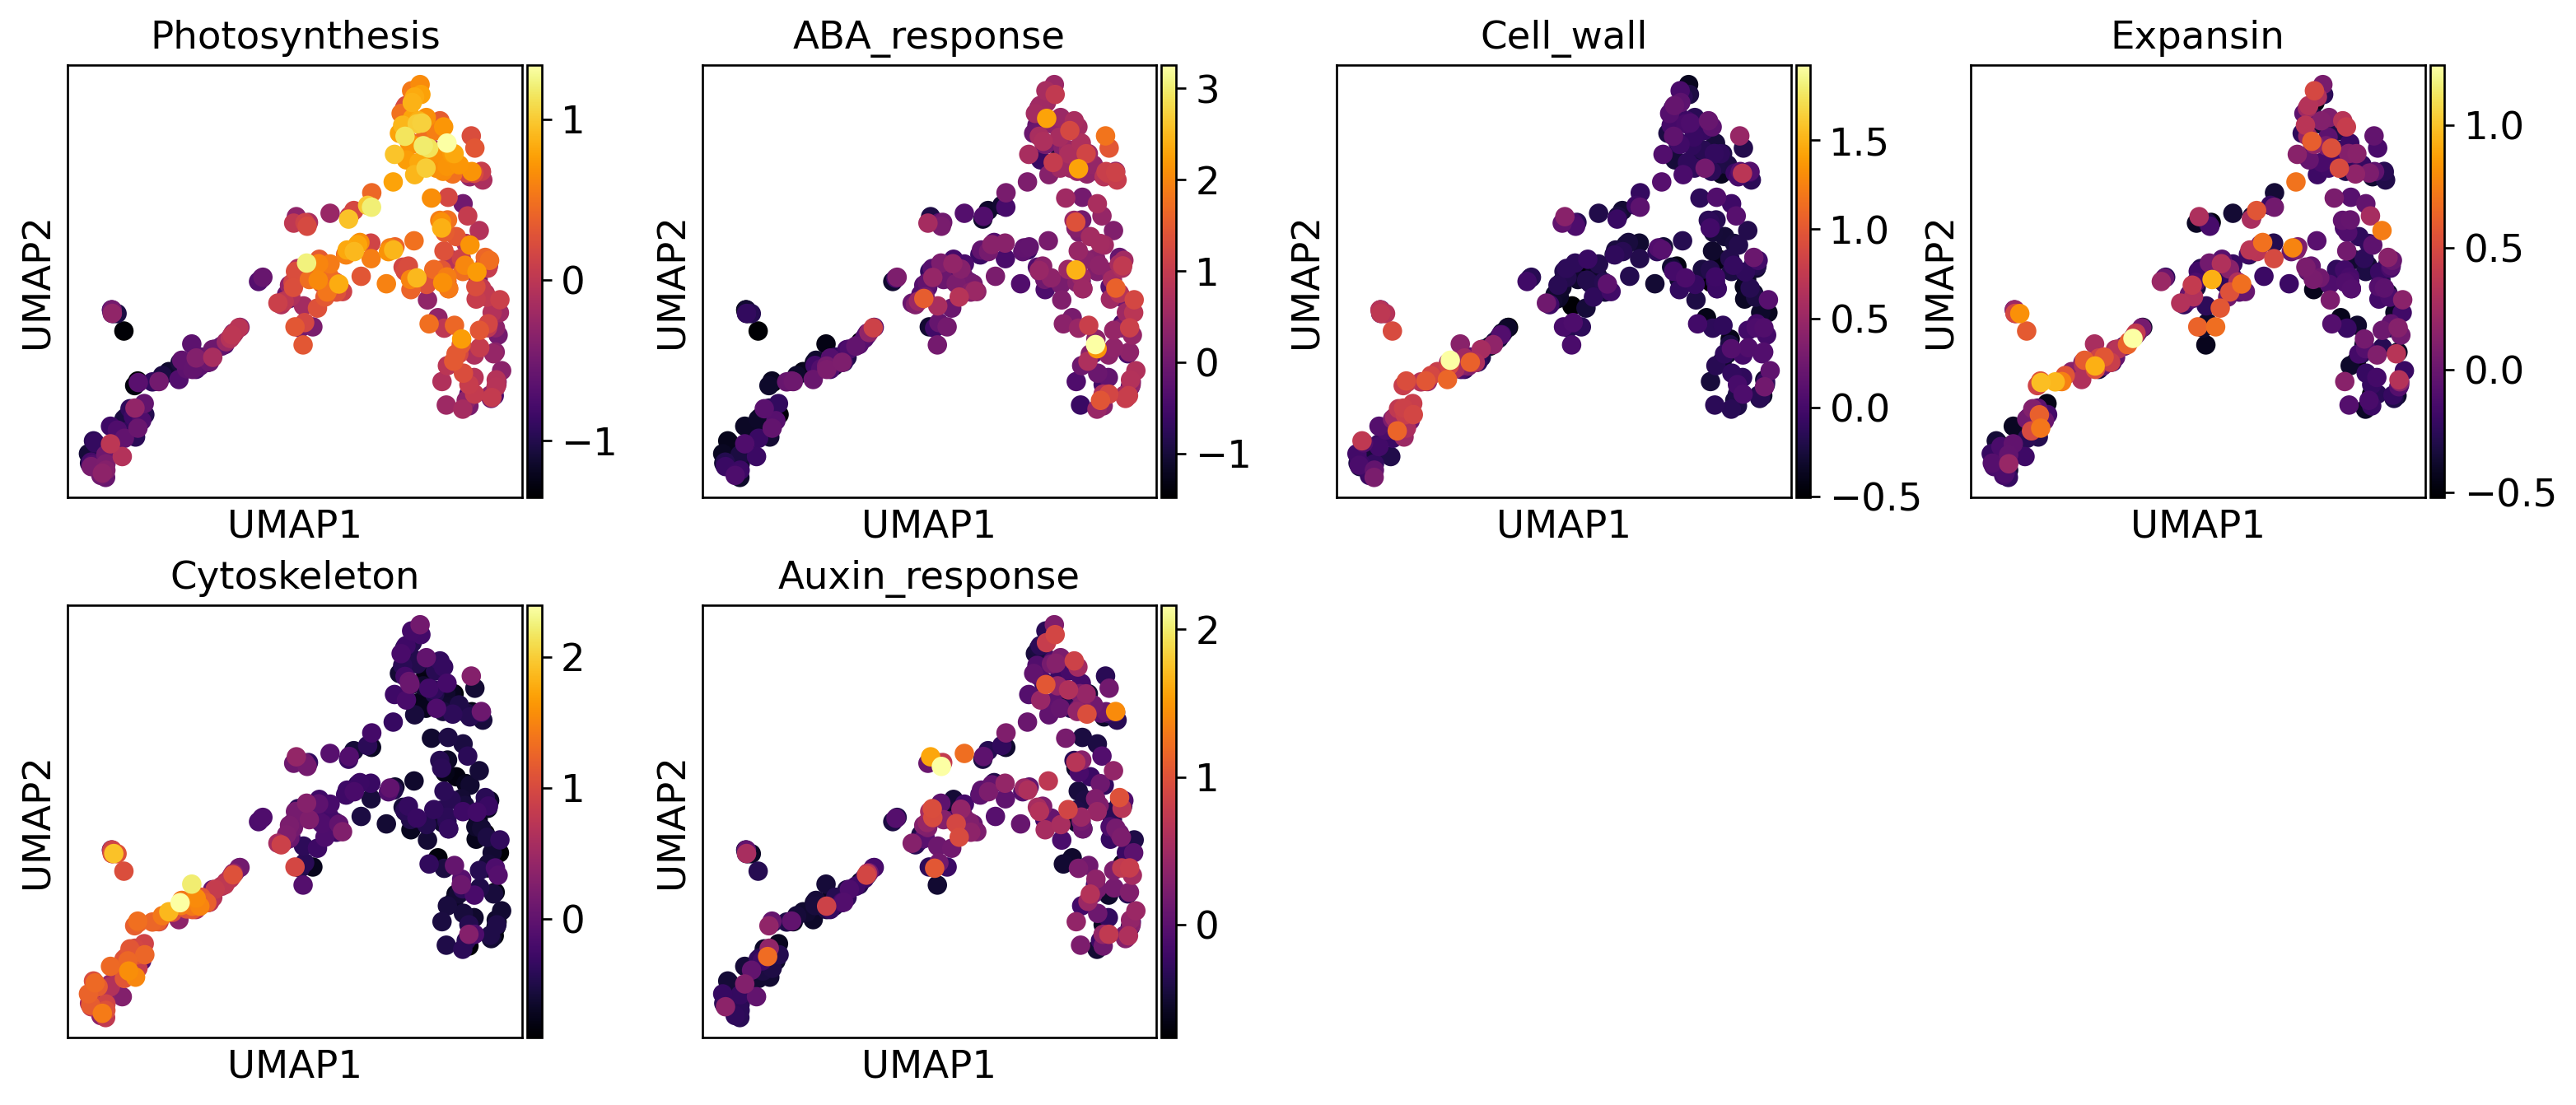

In [ ]:
sc.settings.set_figure_params(figsize=(3,3), dpi=120)
sc.pl.umap(adata_R, color=['Photosynthesis', 'ABA_response', 'Cell_wall', 'Expansin', 'Cytoskeleton', 'Auxin_response'], color_map='inferno', size=200)
sc.settings.set_figure_params(figsize=None, dpi=120)


In [ ]:
import statsmodels.api as sm

In [ ]:
def lowess_reg_rank(adata, gene_score):
          adata_sub = pd.DataFrame(adata.obs['dpt_pseudotime'], index=None)            
          adata_sub[gene_score] = adata.obs[gene_score]
          adata_sub = adata_sub.sort_values(by='dpt_pseudotime')
          adata_sub['rank'] = np.arange(0, len(adata_sub))
          lowess_reg_rank = sm.nonparametric.lowess(adata_sub[gene_score], adata_sub['rank'], frac=0.3)
          lowess_reg_rank_x = lowess_reg_rank[:,0]
          lowess_reg_rank_y = lowess_reg_rank[:,1] - min(lowess_reg_rank[:,1])
          lowess_reg_rank_y = lowess_reg_rank_y/max(lowess_reg_rank_y)
          return lowess_reg_rank_x, lowess_reg_rank_y

In [ ]:
phot_x, phot_y = lowess_reg_rank(adata_R, 'Photosynthesis')
ABA_x, ABA_y = lowess_reg_rank(adata_R, 'ABA_response')
cell_w_x, cell_w_y = lowess_reg_rank(adata_R, 'Cell_wall')
aux_x, aux_y = lowess_reg_rank(adata_R, 'Auxin_response')
exp_x, exp_y = lowess_reg_rank(adata_R, 'Expansin')
cyt_x, cyt_y = lowess_reg_rank(adata_R, 'Cytoskeleton')

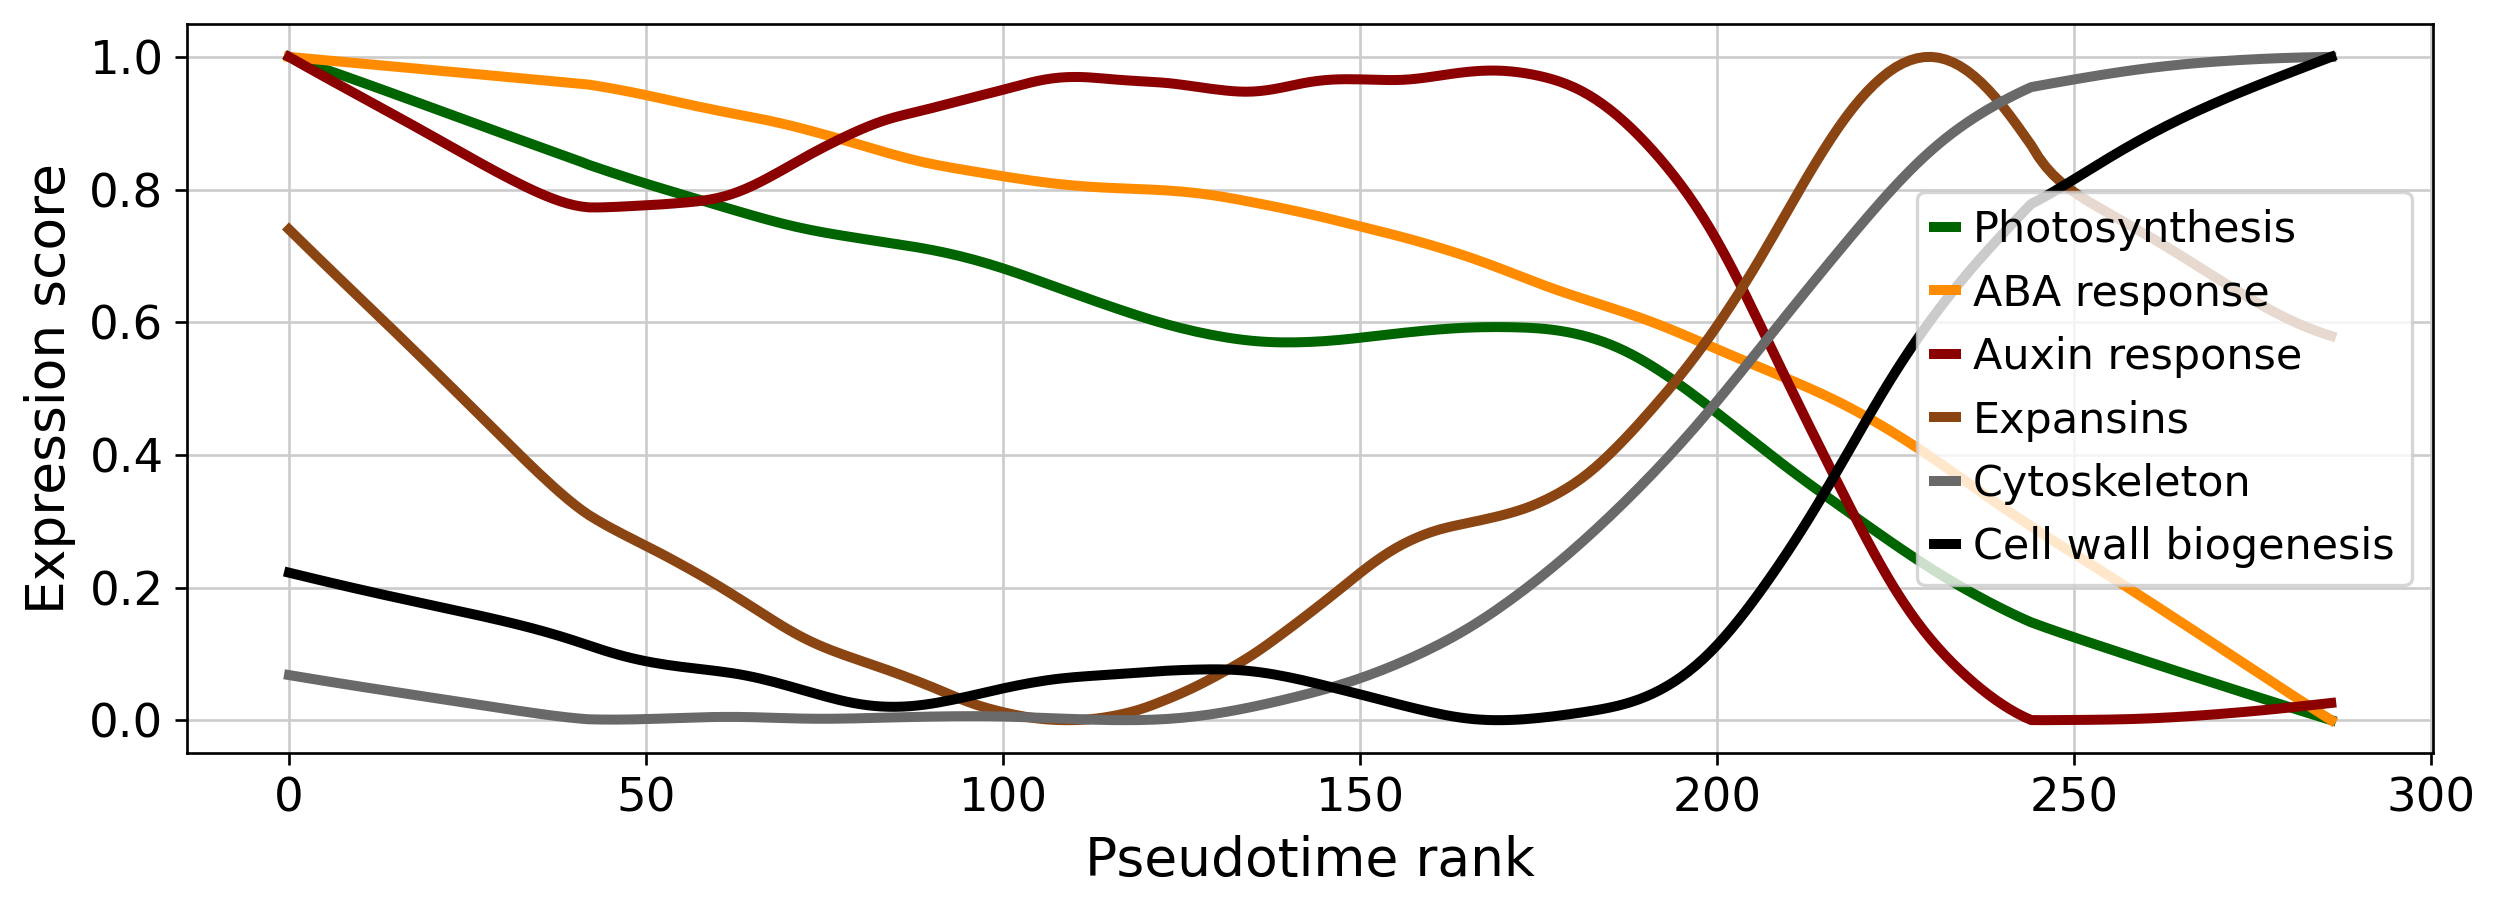

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(phot_x,phot_y, 'darkgreen', linewidth=3) 
plt.plot(ABA_x,ABA_y, 'darkorange', linewidth=3) 
plt.plot(aux_x, aux_y, 'darkred', linewidth=3) 
plt.plot(exp_x,exp_y, 'saddlebrown', linewidth=3) 
plt.plot(cyt_x,cyt_y, 'dimgrey', linewidth=3) 
plt.plot(cell_w_x,cell_w_y, 'k', linewidth=3) 

ax.legend(['Photosynthesis', 'ABA response', 'Auxin response', 'Expansins', 'Cytoskeleton', 'Cell wall biogenesis'])
ax.set_xlabel("Pseudotime rank", size=16)
ax.set_ylabel("Expression score", size=16)

plt.savefig('figures/R_process_dpt_rank.pdf')

In [ ]:
pd.DataFrame(adata_R[adata_R.obs['clusters'].isin(['Pegged Rhizoid'])].obs.index).to_csv("PR_barcodes.csv", header=True,index=False)